In [1]:
import pandas as pd
import random

# To display flow using graphviz
from IPython.display import Image
from graphviz import Digraph


from datetime import datetime, timedelta

In [2]:
flow_data = pd.read_excel('model_in_table.xlsx')

In [3]:
flow_data.head()

,Activity,Next Activity,Probability,Duration_min
0,Start,Activity A,1.0,0
1,Activity A,Activity B,1.0,10
2,Activity B,Activity C,1.0,11
3,Activity C,Activity D,0.3,12
4,Activity C,Activity E,0.7,12


In [4]:
def generate_cases(data):
    
    """
    generate an event log returning cases and activity sequences in a dataframe
    """
    raws = []
    CASE_COUNT = 5

    for i in range(CASE_COUNT):
        CaseID = f'C-{i}'
        activity = data.at[0,'Activity']
        raws.append({'CaseID': CaseID, 'ActivityOrder': 1 , 'Activity' : activity})

        for j in range(50):

            next_activity_probailities = data[data['Activity']==activity]

            if not len(next_activity_probailities)>0:
#                 raws.append({'CaseID': CaseID, 'ActivityOrder': j+2 , 'Activity' : 'End'})
                
                break 

            next_activity = next_activity_probailities.sample(weights=next_activity_probailities['Probability']).iloc[0]['Next Activity']
            raws.append({'CaseID': CaseID, 'ActivityOrder': j+2 , 'Activity' : next_activity})
            activity = next_activity
    
    sequence_log = pd.DataFrame(raws)
    return sequence_log

In [5]:
def flow_chart(flow_data):
    """
    this function create a flowchart using the instructions in flow_data table which include 3 columns "Activity",
    "Next Activity", "probability"
    """
    # Create Digraph object
    flow_chart = Digraph('ProcessFlow', filename='process_flow.gv', format='png')

    # Iterate through DataFrame rows to add nodes and edges
    for _, row in flow_data.iterrows():
        from_activity = row['Activity']
        to_activity = row['Next Activity']
        probability = row['Probability']

        flow_chart.node(from_activity)
        flow_chart.node(to_activity)
        flow_chart.edge(from_activity, to_activity, label=f'Probability: {probability}')

    # Save and render the flowchart
    flow_chart.render(view=False)  # Set view=False to avoid the message

    return Image(filename='process_flow.gv.png')

In [6]:
def flow_chart_w_duration(flow_data):
    """
    this function create a flowchart using the instructions in flow_data table which include 3 columns "Activity",
    "Next Activity", "probability"
    """
    # Create Digraph object
    flow_chart = Digraph('ProcessFlow', filename='process_flow.gv', format='png')

    # Iterate through DataFrame rows to add nodes and edges
    for _, row in flow_data.iterrows():
        activity = row['Activity']
        next_activity = row['Next Activity']
        probability = row['Probability']
        duration = row['Duration_min']

        flow_chart.node(activity)
        flow_chart.node(next_activity)
        flow_chart.node(activity, label=f'{activity}\n {duration} min')
        flow_chart.edge(activity, next_activity, label=f'Prob: {probability}')

    # Save and render the flowchart
    flow_chart.render(view=False)  # Set view=False to avoid the message

    return Image(filename='process_flow.gv.png')

In [7]:
def generate_cases_w_starttimestamp(data):
    
    """
    generate an event log returning cases and activity sequences in a dataframe
    """
    # Main variables
    start_date = datetime(2023, 1, 1, 9, 0, 0)  # January 1, 2023, 09:00:00
    end_date = datetime(2023, 1, 4, 0, 0, 0)    # January 2, 2023, 00:00:00

    start_hour = 9 # i.e. 9am
    end_hour = 17 # i.e. 5pm
    
    work_days = 5 # meaning work days - type 7 if all week

    case_interval = 180 #minues

    # convert the interval to TimeDelta format
    interval = timedelta(minutes=case_interval)

    raws = []
    
    # Create a loop to generate cases between start and end date
    while start_date < end_date:
        if start_date.weekday() < work_days:  # Check if it's a weekday (0: Monday, 1: Tuesday, ..., 4: Friday)
            if start_date.hour >= 9 and start_date.hour < 17:
                timestamp = start_date.strftime("%d-%m-%Y %H:%M:%S")
                
                # create i to number the generated cases
                i=1
                CaseID = f'C-{i}'
                activity = data.at[0,'Activity']
                raws.append({'CaseID': CaseID, 'ActivityOrder': 1 , 'Activity' : activity, 'AssignedTimeStamp':timestamp })
                i+=1

                for j in range(50):

                    next_activity_probailities = data[data['Activity']==activity]

                    if not len(next_activity_probailities)>0:
#                         raws.append({'CaseID': CaseID, 'ActivityOrder': j+2 , 'Activity' : 'End'})

                        break 

                    next_activity = next_activity_probailities.sample(weights=next_activity_probailities['Probability']).iloc[0]['Next Activity']
                    raws.append({'CaseID': CaseID, 'ActivityOrder': j+2 , 'Activity' : next_activity})
                    activity = next_activity
    
        start_date += interval
    
    sequence_log = pd.DataFrame(raws)
    sequence_log['StartTimeStamp'] = None
    sequence_log['EndTimeStamp'] = None
    
    return sequence_log

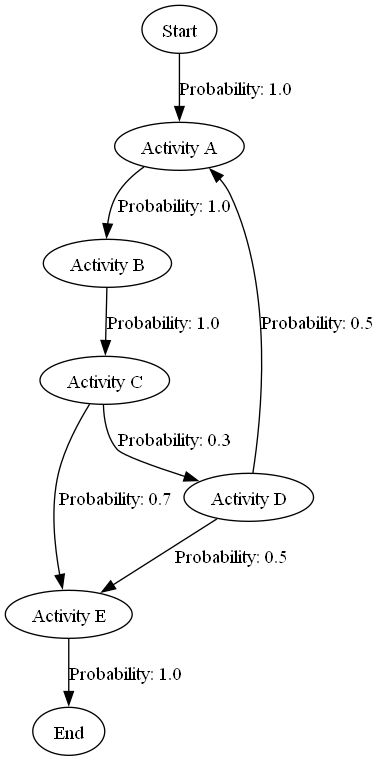

In [8]:
flow_chart(flow_data)

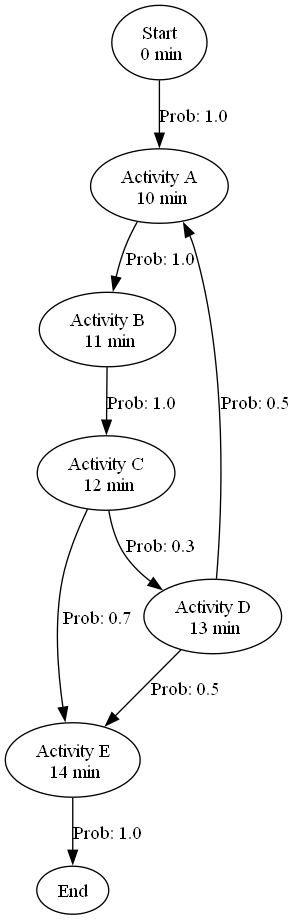

In [9]:
flow_chart_w_duration(flow_data)

In [10]:
generate_cases(flow_data).head()

,CaseID,ActivityOrder,Activity
0,C-0,1,Start
1,C-0,2,Activity A
2,C-0,3,Activity B
3,C-0,4,Activity C
4,C-0,5,Activity E


### Add timestamp to start

In [11]:
output = generate_cases_w_starttimestamp(flow_data)

In [12]:
output.head()

,CaseID,ActivityOrder,Activity,AssignedTimeStamp,StartTimeStamp,EndTimeStamp
0,C-1,1,Start,02-01-2023 09:00:00,None,None
1,C-1,2,Activity A,NaN,None,None
2,C-1,3,Activity B,NaN,None,None
3,C-1,4,Activity C,NaN,None,None
4,C-1,5,Activity D,NaN,None,None


In [13]:
# Add duration data to generated sequence table

sequence_table = pd.merge(output, flow_data[['Activity','Duration_min']].drop_duplicates(), on='Activity', how='left')
sequence_table['Duration_min'].fillna(0, inplace=True)

In [14]:
sequence_table.head(5)

,CaseID,ActivityOrder,Activity,AssignedTimeStamp,StartTimeStamp,EndTimeStamp,Duration_min
0,C-1,1,Start,02-01-2023 09:00:00,None,None,0.0
1,C-1,2,Activity A,NaN,None,None,10.0
2,C-1,3,Activity B,NaN,None,None,11.0
3,C-1,4,Activity C,NaN,None,None,12.0
4,C-1,5,Activity D,NaN,None,None,13.0
